## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [14]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [19]:
from sklearn import preprocessing

In [47]:
from keras.regularizers import l1, l2, l1_l2

In [49]:
from keras.layers import Dropout

In [20]:
train, test = keras.datasets.cifar10.load_data()

In [21]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
#Min Max -1,1
        x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [22]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [43]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256,128,64],l2_ratio=1e-2,drop_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Dropout(drop_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [108]:
"""Code Here
設定超參數
"""
LEARNING_RATE = [1e-1,1e-3]
EPOCHS = 50
DROPOUT=[0.2,0.5]
BATCH_SIZE_EXP =[256,64]
MOMENTUM = 0.95
L2_EXP=1e-12

In [109]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
n=0
for lr in LEARNING_RATE:
    for dropout in DROPOUT:
        for batch_size in BATCH_SIZE_EXP:
            
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print("Experiment with lr = %.6f, dropout_ratio = %.2f,batch_size = % .f " 
                      % (lr,dropout,batch_size))
            model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=L2_EXP,drop_ratio=dropout)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train,
                          epochs=EPOCHS, 
                          batch_size=batch_size, 
                          validation_data=(x_test, y_test), 
                          shuffle=True)
    
            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]
            n=n+1    
            exp_name_tag = "model no.%s" % str(n)
            print(exp_name_tag)
            results[exp_name_tag] = {'train-loss': train_loss,
                                         'valid-loss': valid_loss,
                                         'train-acc': train_acc,
                                         'valid-acc': valid_acc}

Experiment with lr = 0.100000, dropout_ratio = 0.20,batch_size =  256 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
______________________________________________________

50000/50000 [==============================] - 8s 165us/step - loss: 0.9150 - accuracy: 0.6751 - val_loss: 1.3072 - val_accuracy: 0.5610
Epoch 44/50
50000/50000 [==============================] - 8s 163us/step - loss: 0.9113 - accuracy: 0.6758 - val_loss: 1.2771 - val_accuracy: 0.5588
Epoch 45/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.9014 - accuracy: 0.6830 - val_loss: 1.3203 - val_accuracy: 0.5583
Epoch 46/50
50000/50000 [==============================] - 6s 120us/step - loss: 0.8939 - accuracy: 0.6824 - val_loss: 1.2920 - val_accuracy: 0.5604
Epoch 47/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.8880 - accuracy: 0.6867 - val_loss: 1.3144 - val_accuracy: 0.5587
Epoch 48/50
50000/50000 [==============================] - 8s 154us/step - loss: 0.8775 - accuracy: 0.6891 - val_loss: 1.3267 - val_accuracy: 0.5524
Epoch 49/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.8751 - accuracy: 0.6907 - val_loss:

Epoch 35/50
50000/50000 [==============================] - 19s 373us/step - loss: 1.1057 - accuracy: 0.6186 - val_loss: 1.2851 - val_accuracy: 0.5557
Epoch 36/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.1006 - accuracy: 0.6183 - val_loss: 1.2778 - val_accuracy: 0.5511
Epoch 37/50
50000/50000 [==============================] - 14s 270us/step - loss: 1.0964 - accuracy: 0.6205 - val_loss: 1.3118 - val_accuracy: 0.5468
Epoch 38/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.0922 - accuracy: 0.6222 - val_loss: 1.3328 - val_accuracy: 0.5481
Epoch 39/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.0779 - accuracy: 0.6272 - val_loss: 1.3079 - val_accuracy: 0.5394
Epoch 40/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.0771 - accuracy: 0.6271 - val_loss: 1.2774 - val_accuracy: 0.5524
Epoch 41/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.0754 - accuracy:

50000/50000 [==============================] - 9s 171us/step - loss: 1.4528 - accuracy: 0.4923 - val_loss: 1.3402 - val_accuracy: 0.5296
Epoch 27/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.4363 - accuracy: 0.4975 - val_loss: 1.3230 - val_accuracy: 0.5376
Epoch 28/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.4357 - accuracy: 0.4967 - val_loss: 1.3205 - val_accuracy: 0.5320
Epoch 29/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.4300 - accuracy: 0.4986 - val_loss: 1.3264 - val_accuracy: 0.5245
Epoch 30/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4264 - accuracy: 0.5022 - val_loss: 1.3120 - val_accuracy: 0.5352
Epoch 31/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.4198 - accuracy: 0.5043 - val_loss: 1.3128 - val_accuracy: 0.5355
Epoch 32/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.4086 - accuracy: 0.5056 - val_loss:

50000/50000 [==============================] - 19s 372us/step - loss: 1.6264 - accuracy: 0.4265 - val_loss: 1.4596 - val_accuracy: 0.4597
Epoch 18/50
50000/50000 [==============================] - 19s 371us/step - loss: 1.6207 - accuracy: 0.4253 - val_loss: 1.4243 - val_accuracy: 0.4972
Epoch 19/50
50000/50000 [==============================] - 17s 334us/step - loss: 1.6079 - accuracy: 0.4352 - val_loss: 1.4202 - val_accuracy: 0.5005
Epoch 20/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.5992 - accuracy: 0.4380 - val_loss: 1.3927 - val_accuracy: 0.5036
Epoch 21/50
50000/50000 [==============================] - 17s 344us/step - loss: 1.5923 - accuracy: 0.4379 - val_loss: 1.4038 - val_accuracy: 0.5028
Epoch 22/50
50000/50000 [==============================] - 18s 350us/step - loss: 1.5832 - accuracy: 0.4446 - val_loss: 1.4079 - val_accuracy: 0.4887
Epoch 23/50
50000/50000 [==============================] - 18s 351us/step - loss: 1.5845 - accuracy: 0.4444 - va

Epoch 9/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4932 - accuracy: 0.4670 - val_loss: 1.4159 - val_accuracy: 0.4953
Epoch 10/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4722 - accuracy: 0.4748 - val_loss: 1.4066 - val_accuracy: 0.4967
Epoch 11/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4504 - accuracy: 0.4831 - val_loss: 1.3925 - val_accuracy: 0.5022
Epoch 12/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4354 - accuracy: 0.4876 - val_loss: 1.3814 - val_accuracy: 0.5070
Epoch 13/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4149 - accuracy: 0.4937 - val_loss: 1.3704 - val_accuracy: 0.5106
Epoch 14/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4005 - accuracy: 0.5014 - val_loss: 1.3627 - val_accuracy: 0.5136
Epoch 15/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.3842 - accuracy: 0.5048 

50000/50000 [==============================] - 15s 298us/step - loss: 1.9499 - accuracy: 0.3225 - val_loss: 1.6063 - val_accuracy: 0.4334
Epoch 2/50
50000/50000 [==============================] - 14s 290us/step - loss: 1.6781 - accuracy: 0.3986 - val_loss: 1.5134 - val_accuracy: 0.4609
Epoch 3/50
50000/50000 [==============================] - 14s 280us/step - loss: 1.5941 - accuracy: 0.4331 - val_loss: 1.4571 - val_accuracy: 0.4830
Epoch 4/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.5405 - accuracy: 0.4513 - val_loss: 1.4176 - val_accuracy: 0.4952
Epoch 5/50
50000/50000 [==============================] - 14s 280us/step - loss: 1.4957 - accuracy: 0.4677 - val_loss: 1.3962 - val_accuracy: 0.5038
Epoch 6/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.4643 - accuracy: 0.4795 - val_loss: 1.3747 - val_accuracy: 0.5080
Epoch 7/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.4333 - accuracy: 0.4880 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 229us/step - loss: 2.6389 - accuracy: 0.1912 - val_loss: 1.8679 - val_accuracy: 0.3402
Epoch 2/50
50000/50000 [==============================] - 11s 225us/step - loss: 2.1360 - accuracy: 0.2522 - val_loss: 1.8049 - val_accuracy: 0.3581
Epoch 3/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.9910 - accuracy: 0.2821 - val_loss: 1.7651 - val_accuracy: 0.3735
Epoch 4/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.9123 - accuracy: 0.3079 - val_loss: 1.7351 - val_accuracy: 0.3850
Epoch 5/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.8792 - accuracy: 0.3209 - val_loss: 1.7098 - val_accuracy: 0.3929
Epoch 6/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.8364 - accuracy: 0.3360 - val_loss: 1.6827 - val_accuracy: 0.4014
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 451us/step - loss: 2.2444 - accuracy: 0.2308 - val_loss: 1.8061 - val_accuracy: 0.3610
Epoch 2/50
50000/50000 [==============================] - 22s 433us/step - loss: 1.9050 - accuracy: 0.3081 - val_loss: 1.7238 - val_accuracy: 0.3903
Epoch 3/50
50000/50000 [==============================] - 22s 439us/step - loss: 1.8406 - accuracy: 0.3319 - val_loss: 1.6680 - val_accuracy: 0.4078
Epoch 4/50
50000/50000 [==============================] - 24s 473us/step - loss: 1.7986 - accuracy: 0.3512 - val_loss: 1.6279 - val_accuracy: 0.4223
Epoch 5/50
50000/50000 [==============================] - 21s 429us/step - loss: 1.7649 - accuracy: 0.3649 - val_loss: 1.5916 - val_accuracy: 0.4317
Epoch 6/50
50000/50000 [==============================] - 21s 429us/step - loss: 1.7385 - accuracy: 0.3765 - val_loss: 1.5653 - val_accuracy: 0.4432
Epoch 7/50
50000/50000 [==============================] 

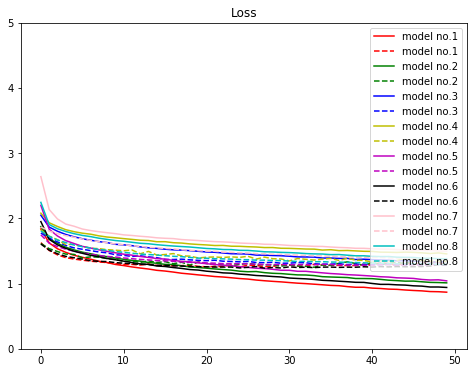

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

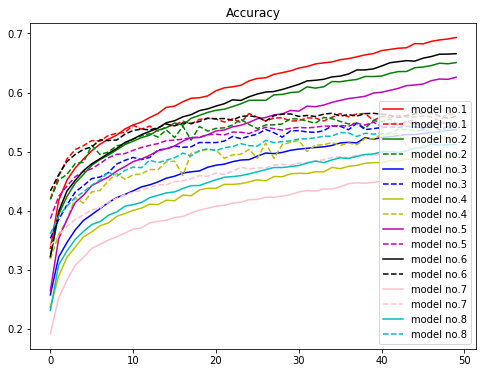

In [113]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [118]:
import pandas as pd

In [146]:
#compute difference between train-loss and valid-loss and put it back to results
#called results for each model
for i,j in results.items():
#create df with 2 columns (train-loss and valid-loss)
    df=pd.DataFrame(results[i]["train-loss"],columns=["Train-loss"])
    df["Valid-loss"]=pd.DataFrame(results[i]["valid-loss"])
#create 3rd columns for the df
    df["dif"]=(df["Valid-loss"]-df["Train-loss"])
    #df
#put the 3rd columns data into generated results
    results[i]["dif"]=df["dif"].to_list()
results["model no.1"].items()

dict_items([('train-loss', [1.8372376272201538, 1.6241674590301514, 1.5341286044692992, 1.479221718788147, 1.4336768837738036, 1.4031905529022217, 1.3734448861694335, 1.3426010689544678, 1.3221181339263917, 1.2929203689193725, 1.2759586486816406, 1.2550781408691407, 1.2381325135421752, 1.2229125888061523, 1.202993518638611, 1.1918911907958984, 1.1761749298095703, 1.1582182917022705, 1.14650665309906, 1.1331244723701477, 1.1213711890411378, 1.1079531163787841, 1.1003901033401489, 1.0888984914016724, 1.077251604576111, 1.0686857306289672, 1.053960061378479, 1.0432397246170044, 1.0339524967575073, 1.025976605796814, 1.015766018447876, 1.0061441744995117, 0.9991268088150025, 0.9903059519195556, 0.9814515114212036, 0.9719020752334595, 0.9673485668563843, 0.9533931698989868, 0.9434330706405639, 0.9431319178009033, 0.9303830394744873, 0.9247233181762695, 0.9150486016464233, 0.9113215518188477, 0.9013763372802734, 0.8939311135482788, 0.8880127244377136, 0.8775250499153138, 0.8751376899528504, 

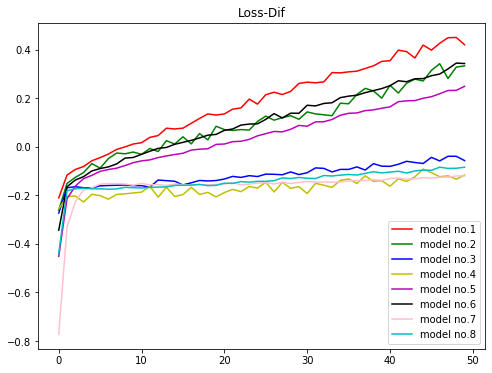

In [148]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['dif'])),results[cond]['dif'], '-', label=cond, color=color_bar[i])
plt.title("Loss-Dif")
plt.legend()
plt.show()

# model no. 3,4,7,8 did a better job